# Setup

## Imports

In [1]:
import pandas as pd

In [2]:
import vaidata, vaikeras

from vaiutils import path_consts
from vaikaggle import dataset_consts

Using TensorFlow backend.


Keras Modules

In [3]:
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

## Define useful variables and functions

In [4]:
for k, v in path_consts('StateFarm'):
    exec(k + '=v')
for k, v in dataset_consts(DIR_DATA, use_sample=False):
    exec(k + '=v')

In [5]:
def pickle_load(filename, default=None, path=DIR_CHECKPOINTS):
    return vaidata.pickle_load(path + '/' + filename + '.p', default)

In [6]:
def pickle_dump(filename, obj, path=DIR_CHECKPOINTS):
    vaidata.pickle_dump(path + '/' + filename + '.p', obj)

In [7]:
def inflate_model(name):
    return vaikeras.inflate_model(DIR_CHECKPOINTS + '/' + name + '.h5', name,
                                  DIR_CHECKPOINTS + '/' + name + '-history.p')

## Load Data

In [8]:
generator = ImageDataGenerator()

In [9]:
def get_batches(directory, batch_size=64):
    return vaikeras.get_batches(directory, generator, batch_size, False)

In [10]:
valid_batches = get_batches(DIR_VALID)

Found 3363 images belonging to 10 classes.


In [11]:
test_batches = get_batches(DIR_TEST)

remaining_batches = get_batches(DIR_TEST, 1)
remaining_batches.total_batches_seen = test_batches.batch_size * \
    test_batches.num_batches
remaining_batches.num_batches = remaining_batches.samples - \
    remaining_batches.total_batches_seen

Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.


## Load Model

In [12]:
K.clear_session()
K.set_learning_phase(False)

model = inflate_model('FullyConvNet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
__________

# Calculate Clips

In [13]:
val_preds = model.predict_generator(
    valid_batches, valid_batches.num_batches, verbose=1)

52/52 [==============================] - 10s    


In [14]:
def get_loss(clip_low=0, clip_high=1):
    y_pred = val_preds.clip(clip_low, clip_high)
    y_pred = y_pred.clip(1e-15, 1 - 1e-15)
    y_pred = y_pred / y_pred.sum(1, keepdims=True)
    y_true = to_categorical(valid_batches.classes)[:len(y_pred)]
    return -((y_true * np.log(y_pred)).sum(1)).mean()

In [15]:
num_clips = 100
val_loss_matrix = np.zeros((num_clips, num_clips))
for l, clip_low in enumerate(np.linspace(0, 0.5, num_clips)):
    for h, clip_high in enumerate(np.linspace(0.5, 1, num_clips)):
        val_loss_matrix[l, h] = get_loss(clip_low, clip_high)

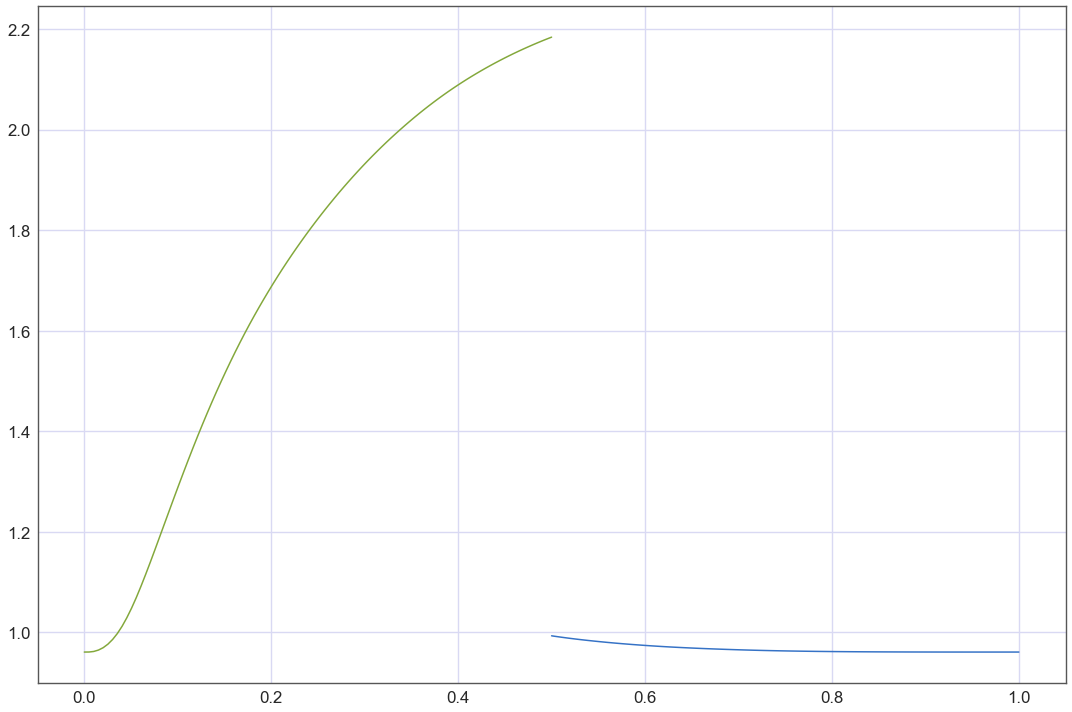

In [16]:
plot(np.linspace(0.5, 1, num_clips), val_loss_matrix[0, :])
plot(np.linspace(0, 0.5, num_clips), val_loss_matrix[:, -1])

In [17]:
best_clip = np.unravel_index(val_loss_matrix.argmin(), val_loss_matrix.shape)

best_clip = (np.linspace(0, 0.5, num_clips)[best_clip[0]],
             np.linspace(0.5, 1, num_clips)[best_clip[1]])

print("Best clip is", best_clip)
print("You can expect a loss of", get_loss(best_clip[0], best_clip[1]))

Best clip is (0.0, 0.97979797979797989)
You can expect a loss of 0.960569143878


# Prepare Submissions

In [18]:
predictions = model.predict_generator(test_batches,
                                      test_batches.num_batches, verbose=1)

remaining_predictions = model.predict_generator(remaining_batches,
                                                remaining_batches.num_batches, verbose=1)

predictions = np.vstack([predictions, remaining_predictions])

42/46 [==========================>...] - ETA: 0s

In [19]:
assert len(predictions) == test_batches.samples, "Something wrong with test batch creation. Check the batch sizes. If confused, just use a single test batch with unit batch size."

In [20]:
column_names = []
for i in range(10):
    column_names.append('c' + str(i))

In [21]:
for i in range(test_batches.samples):
    test_batches.filenames[i] = test_batches.filenames[i][8:]

In [22]:
submission = pd.DataFrame(predictions.clip(best_clip[0], best_clip[1]), columns=column_names)
submission.insert(0, 'img', test_batches.filenames)

In [23]:
submission.sort_values('img').to_csv(DIR_OUTPUT + '/' + model.name + '-submission.csv', index=False)